In [1]:
include("../rollout_bayesian_optimization.jl")

deterministic_solve (generic function with 1 method)

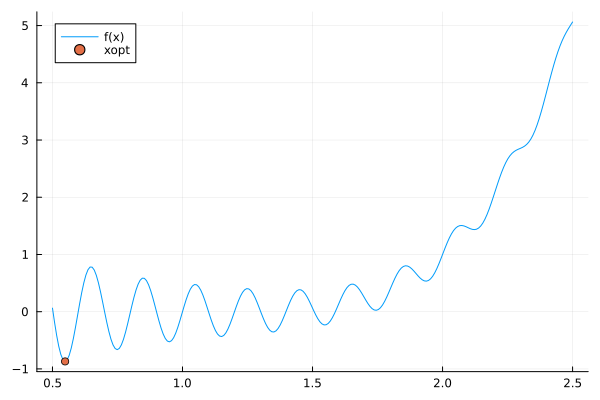

In [11]:
testfn = TestGramacyLee()
tplot(testfn)

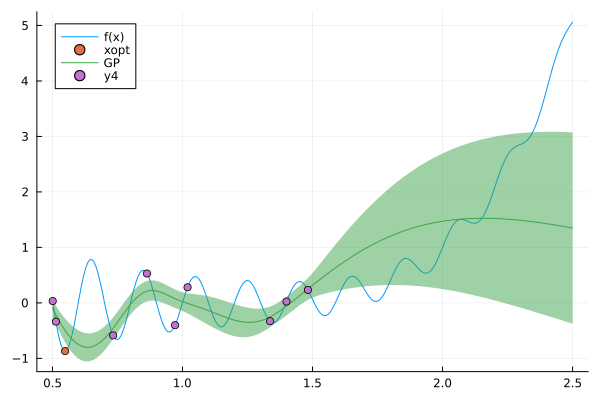

In [31]:
MC_SAMPLES = 1
NUMBER_OF_STARTS = 16
HORIZON = 1
USE_LDS = false
INITIAL_SAMPLES = 9

# Gaussian process hyperparameters
θ, σn2 = [1.], 1e-4
θinit = [0.]
kernel = Matern52()

lbs, ubs = get_bounds(testfn)
midpoint = (ubs + lbs) / 2
domain = dense_1D_discretization(lb=first(lbs), ub=first(ubs), stepsize=.01)

# Initialize the trajectory parameters
tp = TrajectoryParameters(
    start=midpoint,
    horizon=HORIZON,
    mc_iterations=MC_SAMPLES,
    use_low_discrepancy_sequence=USE_LDS,
    spatial_lowerbounds=lbs,
    spatial_upperbounds=ubs,
    hypers=θinit
)
es = ExperimentSetup(number_of_starts=NUMBER_OF_STARTS, tp=tp)

Xinit = randsample(INITIAL_SAMPLES, testfn.dim, lbs, ubs)
yinit = testfn(Xinit)
sur = Surrogate(kernel, Xinit, yinit, decision_rule=EI(), σn2=σn2);
# sur = optimize(sur, Matern52, lowerbounds=[0.], upperbounds=[5.])

tplot(testfn)
plot!(domain, [sur([x], θinit).μ for x in domain], ribbons=2sqrt.([sur([x], θinit).σ for x in domain]), label="GP")
scatter!(sur.X[:, 1:INITIAL_SAMPLES]', sur.y[1:INITIAL_SAMPLES])

In [39]:
@allocations begin
    for budget in 1:100
        horizon = 1
        
        for simulation in 1:100
            fsur = FantasySurrogate(sur, horizon)
            for _ in 0:horizon
                xn = vec(randsample(1, testfn.dim, lbs, ubs))
                condition!(fsur, xn, testfn(xn))
            end
        end

        xn = vec(randsample(1, testfn.dim, lbs, ubs))
        sur = condition!(sur, xn, testfn(xn))        
    end
end

6610876

In [40]:
to(6610876, key="MB")

"6.304622650146484MB"